# Classification Metrics

As we have seen through this specialization we tend to use *sklearn's classification report* to summarize model performance. If we had a model to predict whether a customer would be retained, or would put their account on hold, we might observe something like the following table:

In [1]:
from sklearn.metrics import classification_report
import numpy as np

y_true = [0,1,0,2,1,0,0,2,1,1,0,1]
y_pred = [0,0,0,2,1,0,2,1,2,1,0,1]
target_names = np.array(['retained', 'unretained', 'on hold'])
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    retained       0.80      0.80      0.80         5
  unretained       0.75      0.60      0.67         5
     on hold       0.33      0.50      0.40         2

   micro avg       0.67      0.67      0.67        12
   macro avg       0.63      0.63      0.62        12
weighted avg       0.70      0.67      0.68        12



Looking at each class in terms of the *F1 score* is a convenient way to summarize the classifier's results. We are going to quickly review how we obtain the numbers in this table.

To get the `F1_score` and its component measures of precision and recall we need to first start with a *confusion matrix*

|             |Predicted False $(\hat{Y}=0)$|Predicted True $(\hat{Y}=1)$|
|------------ |-----------------------------|----------------------------|
|True (Y=0)   |True Negatives (TN)          |False Positive (FP)         |
|True (Y=1)   |False Negatives (FN)         |True Positive (TP)          |

In [2]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[4 0 1]
 [1 3 1]
 [0 1 1]]


It can be a useful communication tool to embed an image of the confusion matrix in reports and dashboards.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[np.sort(np.unique(np.union1d(y_true, y_pred)))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    if normalize:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0,vmax=1.0)
    else:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim((-0.5,len(classes)-0.5))
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return(ax)

Normalized confusion matrix
[[0.8 0.  0.2]
 [0.2 0.6 0.2]
 [0.  0.5 0.5]]


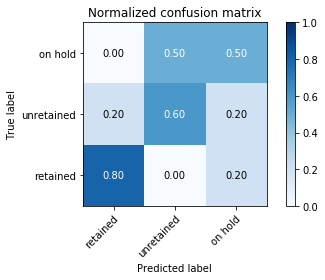

In [4]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=target_names, 
                      normalize=True, title='Normalized confusion matrix')
plt.show()

Note that the images rescale the TP, FP, TN, FN counts to 0-1 scale so that one confusion matrix may easily compared to another.

There are many ways to evaluate the confusion matrix:

* $Accuracy= \frac{TN + TP}{FP+FN+TP+TN}$: overall proportion correct
* $Precision= \frac{TP}{TP+FP}$: proportion called true that are correct
* $Recall=\frac{TP}{TP+FN}$: proportion of true that are called correctly

The `F1_score` is the harmonic mean of precision and recall.

$F_1 = \frac{2}{\frac{1}{recall} + \frac{1}{precision}}$

The F1_score is actually a special case of the $F_\beta$ score, where the weight of recall and precision is evenly balanced. The F_score can be also written as:

$F_\beta = (1 + \beta^2) \frac{precision \times recall}{(\beta^2\times precision) + recall}$

If we set, for example, $\beta=2$ then the metric weighs recall higher than precision. Conversely, with $\beta=0.5$ precision is given more importance than recall. The customization of the F_score is an important tool that can be used to align the model with the needs of a business opportunity. We would consider increasing $\beta$ in a situation where false negatives are more important. For example, if your model was used to screen X-Ray images of airport luggage for manual inspection, a false positive is not as potentially costly as a false negative. Using, scikit-learn, it would be implemented as follows: 

In [5]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer

rs=42
X, y = make_classification(n_samples=3000, n_features=50, n_informative=20,
                           n_redundant=2, n_classes=2,
                           n_clusters_per_class=3,
                           weights=[0.5, 0.5],
                           class_sep=0.9, random_state=rs)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs, stratify=y)

model = SVC(kernel='rbf')
ftwo_score = make_scorer(fbeta_score, beta=2, average='weighted')


param_grid = {
    'C': [0.1,0.5,1.0,10.0],
    'gamma': [0.01,0.1]
}

grid = GridSearchCV(model, param_grid=param_grid, scoring=ftwo_score, cv=3)

## fit model
grid.fit(X_train, y_train)

## evaluate the model fit
y_pred = grid.predict(X_test)
print("F1_score", round(f1_score(y_test, y_pred,labels=y_pred),3))
print("Fbeta_score", round(fbeta_score(y_test, y_pred, labels=y_pred, beta=2.0),3))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Pyth

F1_score 0.911
Fbeta_score 0.914


The F1_score also has an important parameter *average*. This parameter is directly related to how you would like to summarize your scores across classes.

**micro** - Calculate metrics globally by considering each element of the label indicator matrix as a label.

**macro** - Calculate metrics for each label and find their unweighted mean. This does not take label imbalance into account.

**weighted** - Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

**samples** - Calculate metrics for each instance and find their average.

**Warning: The average parameter can significantly change the behavior and performance of your model, especially when the classes are imbalanced.**

There are a number of other metrics including *hamming_loss*, *hinge_loss*, *matthews_corrcoef*, *cohen_kappa_score*, *brier_score_loss*, and *jaccard_similarity* that have specific use cases.

As a general rule for both regression and classification problems, if the function name ends in *_score*, it is a value we are trying to maximize. If the function name ends in *_error* or *_loss* then lower values are the target.